In [20]:
using Plots
using Random
using Lattice
include("./phase.jl")
include("./gr.jl")
using ColorSchemes
using DataFrames, CSV
using LaTeXStrings

In [21]:
function latticeplot2D(ltc, psi)
    ms = Int64[]
    ns = Int64[]
    for i in 1:length(psi)
        m,n, _ = site.(Ref(ltc), i)
        push!(ms, m)
        push!(ns, n)
    end
    mn = hcat(ms, ns)
    p = scatter(ms, ns, marker_z = abs.(psi), 
        msw = 0, c = :lajolla, frame = :box, label = false, 
        markersize = 5.5, colorbar_title = L"\psi", size = (500, 500), thickness_scaling = 1.2)
    xlabel!(L"x")
    ylabel!(L"y")
    return p
end

function projectedlatticeplot2D(ltc, psi, j; direction = :x)
    ns = Int64[]
    idx = Int64[]
    
    for i in 1:length(psi)
        m,n, _ = site.(Ref(ltc), i)
        if direction == :x
            if m == j
                push!(idx, i)
                push!(ns, n)
            end
        elseif direction == :y
            if n == j
                push!(idx, i)
                push!(ns, m)
            end
        end
    end
    p = plot(ns, abs.(psi[idx]), 
        msw = 0, frame = :box, label = false, m = :circle, line = :solid,
        markersize = 5.5, size = (500, 500), thickness_scaling = 1.2)
    xlabel!(L"x")
    ylabel!(L"y")
    return p
end

function latticeplot2d_data(ltc, psi)
    ms = Int64[]
    ns = Int64[]
    for i in 1:length(psi)
        m,n, _ = site.(Ref(ltc), i)
        push!(ms, m)
        push!(ns, n)
    end
    mn = hcat(ms, ns)
    df = DataFrame(x = ms, y=ns, psi_abs = abs.(psi))
    return df
end


function iter_tuple(i::Integer, j::Integer, minval::Integer, X::Integer, Y::Integer)
    if j != Y
        return (i, j+1)
    elseif i != X
        return (i + 1, minval)
    elseif i == X && j == Y
        return (Inf, Inf)
    end
end

"""
check the range of hoppings
"""
function hop_checker(ltc, H)
    if !(ltc.M >= 20 && ltc.N >= 20)
        error("The lattice size is not big enough")
    end
    U = ltc.U
    M = ltc.M ÷ 2
    N = ltc.N ÷ 2
    
    idx1 = [index(ltc, (M, N, u)) for u in 1:U]
    flag = true
    i = -10
    j = -10
    nzs = Tuple{Int64, Int64}[];
    while i != Inf && j != Inf
        idx2 = [index(ltc, (M+i, N+j, u)) for u in 1:U]
        iszeroblock = all(abs.(H[idx1, idx2]) .< 1E-13)
        if !iszeroblock
            push!(nzs, (i, j))
        end
        i, j = iter_tuple(i, j, -10, ltc.M - M, ltc.N - N)
    end
    return nzs
end  


"""
check the range of hoppings
"""
function pbc_remover!(ltc, H)
    hops = hop_checker(ltc, H)
    for i in 1:length(hops)
        x, y = hops[i]
        for m in 1:ltc.M, n in 1:ltc.N
            if (m + x > ltc.M) || (n + y > ltc.N) || (m + x < 1) || (n + y < 1)    
                idx1 = [index(ltc, (m, n, u)) for u in 1:ltc.U]
                idx2 = [index(ltc, (m+x,n+y, u)) for u in 1:ltc.U]
                H[idx1, idx2] = zeros(eltype(H), ltc.U, ltc.U)
                H[idx2, idx1] = zeros(eltype(H), ltc.U, ltc.U)
            end
        end
    end
    dropzeros!(H)
end  

function grscan(;L = 10, θ = 0.25, R = 10, rng=Random.GLOBAL_RNG, range = 1:5)
    grs = Array{Float64}[]
    ltc = Lattice2D(L, L, 1)
    for r in 1:R
        H = ham_sf_pbc(L = L, θ = θ, rng = rng)
        vals, vecs = eigen(Hermitian(Matrix(H)), range)
        
        for i in 1:length(vals)
            lw = LatticeWave(ltc, log.(abs.(vecs[:, i])));
            gr = filter(!isnan, eig_corr_full(lw));
            push!(grs, gr)
        end
    end
    return vec(mean(reduce(hcat, grs), dims = 2))


end

grscan (generic function with 1 method)

In [22]:
L = 30
ltc = Lattice2D(L, L, 1)
H = ham_sf_obc(L = L, θ = big(0.25), rng = MersenneTwister())

900×900 SparseMatrixCSC{Complex{BigFloat}, Int64} with 20557 stored entries:
⣻⣾⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠙⢮⡻⣿⢟⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⢮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡳⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳⣄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣵⣿⣮⡳⣄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣿⣿⣮⡳
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⡿⣯

In [23]:
vals, vecs = eigen(Hermitian(Matrix(ComplexF64.(H))), 1:10);
ltc = Lattice2D(L, L, 1)

Lattice2D{Int64}(30, 30, 1)

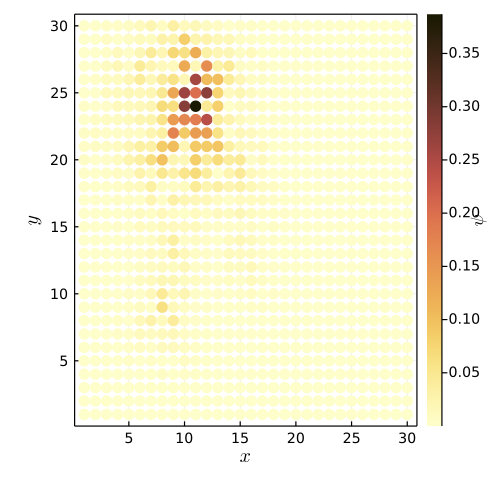

In [28]:
p1 = latticeplot2D(ltc, vecs[:, 3])

In [9]:
p2 = projectedlatticeplot2D(ltc, vecs[:, 14], 1, direction=:y)
plot!(yaxis = :log10)

LoadError: BoundsError: attempt to access 900×10 Matrix{ComplexF64} at index [1:900, 14]

In [343]:
lw = LatticeWave(ltc, log.(abs.(vecs[:, 10])));
gr = filter(!isnan, eig_corr_full(lw));

In [344]:
abs.(vecs[:, 1])

900-element Vector{Float64}:
 0.00086198218312079
 0.0003780055394257626
 0.0005685711061595561
 0.0009890803887759596
 0.00024626383452940677
 0.00040893876908910476
 0.00016408494668291635
 0.000268362709712131
 0.0002532123305269549
 5.2900810258832934e-5
 7.592724219616626e-5
 7.357213096633225e-5
 9.869980397062067e-5
 ⋮
 0.00024014342773069264
 0.00043099222246886895
 0.0006492389767830306
 0.0011416721787487452
 0.0009253471245447137
 0.0021326889229116856
 0.001976918626895407
 0.0005680605501754418
 0.0014985805408032817
 0.0019289906205426895
 0.0005160148781740429
 0.002194254263788832

In [345]:
gr2 = eig_corr(lw, (1, 1), direction = :y);

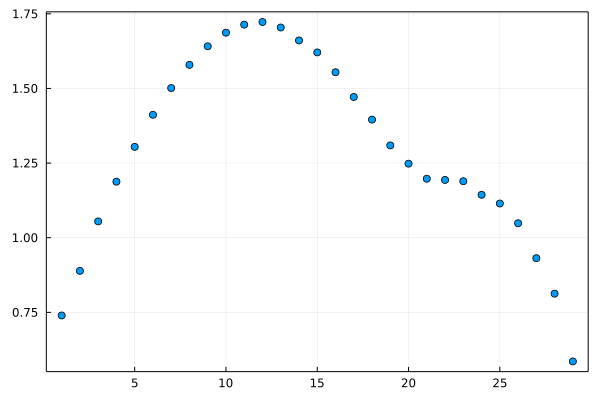

In [346]:
scatter(gr, legend = false, frame = :box)

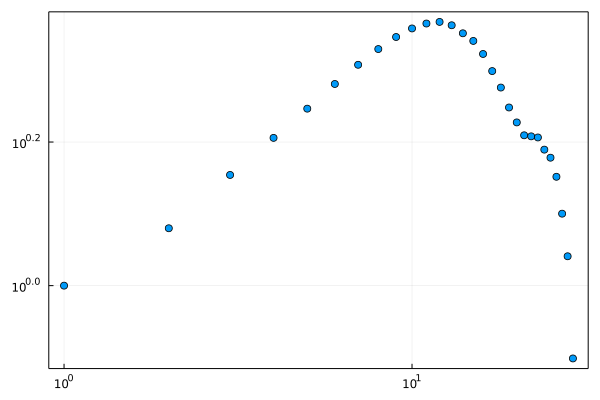

In [348]:
scatter(gr/gr[1], yaxis = :log10, xaxis = :log10, legend = false, frame = :box)

In [32]:
procs()

9-element Vector{Int64}:
 1
 2
 3
 4
 5
 6
 7
 8
 9